# ST456 2025 - Group 'I learn deep' project
# Hybrid Autoencoder-BiLSTM model for RUL Prediction on Nasa's C-MAPSS datasets
This notebook proposes a hybrid autoencoder-BiLSTM architecture that is trained and evaluated on all four C-MAPSS datasets using 5-fold cross-validation and dispersion plots showcasing the predicted RUL of the model vs. the actual RUL derived from the test data.

#### Import libraries and mount google drive

In [ ]:
# Import libraries
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, losses, regularizers, Model, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Reshape, Concatenate, TimeDistributed, Bidirectional, Dropout, Flatten, BatchNormalization, LayerNormalization, Add
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.model_selection import KFold

# Mount Google Drive
from google.colab import drive
# Set working directory in google drive to import datasets
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Ensure that files are in the specified path
file_path = '/content/drive/MyDrive/Colab Notebooks/I Learn Deep/tensors'
print(os.listdir(file_path))

['FD001_X_augmented.npy', 'FD001_y_augmented.npy', 'FD001_metadata.txt', 'FD002_X_augmented.npy', 'FD002_y_augmented.npy', 'FD002_metadata.txt', 'FD003_X_augmented.npy', 'FD003_y_augmented.npy', 'FD003_metadata.txt', 'FD004_X_augmented.npy', 'FD004_y_augmented.npy', 'FD004_metadata.txt', 'FD004_test_windows.npz', 'FD003_test_windows.npz', 'FD002_test_windows.npz', 'FD001_test_windows.npz', 'normalized_data.pkl']


## Set-up for building, training and evaluating hybrid autoencoder model
#### Input-, Training- and Hyperparameters

In [ ]:
# Set model input parameters
latent_dim = 32
time_steps = 30

# Define weights for RUL vs reconstruction loss
alpha = 1.0
beta = 0.2

# Model training parameters
n_epochs = 100
batch_size = 128
es_patience = 15
lr_patience = 5
min_lr = 0.00001
factor = 0.5
NUM_FOLDS = 5

#### Functions to build, train and evaluate model

In [ ]:
# Build hybrid autoencoder architecture
def build_hybrid_autoencoder(X_train, latent_dim, time_steps):
    inputs = Input(shape=(time_steps, X_train.shape[2]))

    # Encoder block for temporal feature extraction
    x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv1D(filters=latent_dim, kernel_size=3, padding='same', activation='relu')(x)
    encoded = layers.BatchNormalization()(x)

    # Decoder block for reconstruction loss
    x_rec = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(encoded)
    x_rec = layers.BatchNormalization()(x_rec)
    x_rec = layers.Dropout(0.3)(x_rec)
    x_rec = layers.Conv1D(filters=X_train.shape[2], kernel_size=5, padding='same', activation='sigmoid')(x_rec)
    x_rec = layers.BatchNormalization(name='reconstruction')(x_rec)

    # BiLSTM block for sequence modeling on encoded representation
    x_seq = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(encoded)
    x_seq = layers.Dropout(0.2)(x_seq)
    x_seq = layers.Bidirectional(layers.LSTM(64))(x_seq)
    x_seq = layers.Dropout(0.2)(x_seq)

    # Output layer
    rul_pred = layers.Dense(1, activation='linear', name='rul')(x_seq)

    # Final model
    model = Model(inputs=inputs, outputs=[rul_pred, x_rec])
    return model

# Define asymmetric mse as new experimental metric
def asymmetric_mse(y_true, y_pred):
    error = y_pred - y_true
    under = tf.square(error) * tf.cast(error < 0, tf.float32)
    over = tf.square(error) * tf.cast(error >= 0, tf.float32) * 2
    return tf.reduce_mean(under + over)

# Define function to train the hybrid autoencoder model with k-fold CV for each dataset
def train_hybrid_autoencoder(X_train, y_train, X_val, y_val, name):

    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
    fold_models = []

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=es_patience, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=lr_patience, min_lr=min_lr)
    ]

    fold = 1
    for train_idx, val_idx in kf.split(X_train):
        print(f"Training fold {fold}/{NUM_FOLDS}")
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        model = build_hybrid_autoencoder(X_train=X_fold_train, latent_dim=latent_dim, time_steps=time_steps)

        model.compile(
            optimizer='adam',
            loss=['mse', 'mse'],
            loss_weights=[alpha, beta],
            metrics=[RootMeanSquaredError(name='rmse'), None]
        )

        history = model.fit(
            X_fold_train, [y_fold_train, X_fold_train],
            validation_data=(X_fold_val, [y_fold_val, X_fold_val]),
            epochs=n_epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )

        # Print fold results
        val_loss = history.history['val_loss'][-1]
        val_rmse = history.history['val_rul_rmse'][-1]
        print(f"Fold {fold} results: val_loss={val_loss:.4f}, val_rmse={val_rmse:.4f}")

        # Save model
        fold_models.append(model)
        fold += 1

    # Evaluate ensemble on validation set
    val_preds = ensemble_predict(fold_models, X_val)
    val_rmse = np.sqrt(np.mean((val_preds.flatten() - y_val) ** 2))
    val_score = phm_score(y_val, val_preds.flatten())

    print(f"\n{name} Validation Results:")
    print(f"RMSE: {val_rmse:.4f}")
    print(f"Score: {val_score:.4f}")

    return fold_models

# Define function to make combined prediction based on all 5 CV models
def ensemble_predict(models, X):
    all_preds = []
    for model in models:
        preds = model.predict(X)
        y_pred = preds[0] if isinstance(preds, (list, tuple)) else preds
        y_pred = np.asarray(y_pred).flatten()
        all_preds.append(y_pred)

    # Stack and average
    all_preds = np.stack(all_preds, axis=0)
    avg_preds = np.mean(all_preds, axis=0)
    return avg_preds

# Define RMSE metric
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

# Define C-MAPSS Score metric
def phm_score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        if pred > true:
            score = np.exp(np.abs(pred - true) / 13) - 1
        else:
            score = np.exp(np.abs(pred - true) / 10) - 1
        scores.append(score)
    return np.sum(scores)

# Define function to evaluate trained model on test set
def evaluate_test_set(models, X_test, y_test, name):

    # Generate predictions
    test_preds = ensemble_predict(models, X_test)

    # Calculate metrics
    test_rmse = np.sqrt(np.mean((test_preds.flatten() - y_test) ** 2))
    test_score = phm_score(y_test, test_preds.flatten())

    print(f"\n{name} Test Results:")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"Score: {test_score:.4f}")

    return test_rmse, test_score, test_preds

# Define function to plot dispersion plot per dataset
def evaluate_model(prediction_results, dataset_names):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.tight_layout(pad=5.0)

    scores = {}

    for i, name in enumerate(dataset_names):
        y_test = prediction_results[name]['actual']
        y_pred = prediction_results[name]['test_preds']

        # Evaluate
        rmse_score = rmse(y_test, y_pred)
        phm = phm_score(y_test, y_pred)
        scores[name] = {'rmse': rmse_score, 'phm': phm}

        # Plot
        ax = axes[i // 2, i % 2]
        ax.scatter(y_test, y_pred, alpha=0.6)
        mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
        ax.plot([mn, mx], [mn, mx], 'r--')
        ax.set_title(f"{name}\nRMSE: {rmse_score:.2f}, PHM: {phm:.2f}")
        ax.set_xlabel('Actual RUL')
        ax.set_ylabel('Predicted RUL')
        ax.grid(True)

    plt.savefig(f'{save_dir}/All_Plots_Actual_vs_Predicted_RUL.png')
    plt.show()

    return scores

## Pipeline for evaluation on all four datasets

In [ ]:
# Save Dataset names in list
dataset_names = ["FD001", "FD002", "FD003", "FD004"]

# Set base path
base_path = '/content/drive/MyDrive/Colab Notebooks/I Learn Deep/tensors'

# Paths to directories for loading data and saving plots
file_path = '/content/drive/MyDrive/Colab Notebooks/I Learn Deep/tensors'

def pipeline(dataset_names, base_path):
    results = {}
    for name in dataset_names:
        # Load preprocessed data (adjust paths as needed)
        X = np.load(f'{base_path}/{name}_X_augmented.npy')
        y = np.load(f'{base_path}/{name}_y_augmented.npy')
        test_data = np.load(f'{base_path}/{name}_test_windows.npz')
        X_test = test_data['X_test']
        y_test = test_data['y_test']

        # Define validation and test split
        X_train, X_val, y_train, y_val = train_test_split(
            X, y,
            test_size=0.2,
            random_state=42,
            stratify=np.floor(y/10).astype(int)
        )

        print(f"[{name}] Train shape: {X_train.shape}, Val shape: {X_val.shape}")

        # Maximum RUL transformation: Set all RUL values >= 130 to 130
        y_train[y_train >= 130] = 130

        # Run
        fold_models = train_hybrid_autoencoder(X_train, y_train, X_val, y_val, name=name)
        test_rmse, test_score, test_preds = evaluate_test_set(models=fold_models, X_test=X_test, y_test=y_test, name=name)

        # Store results
        results[name] = {
            'test_rmse': test_rmse,
            'test_score': test_score,
            'test_preds': test_preds,
            'actual': y_test
        }

    # Plot dispersion plot
    evaluate_model(prediction_results=results, dataset_names=dataset_names)

    # Print results dictionary
    print(results)
    return results

[FD001] Train shape: (11475, 30, 15), Val shape: (2869, 30, 15)
Training fold 1/5
Fold 1 results: val_loss=24.0864, val_rmse=4.9051
Training fold 2/5
Fold 2 results: val_loss=46.9756, val_rmse=6.8520
Training fold 3/5
Fold 3 results: val_loss=26.0650, val_rmse=5.1028
Training fold 4/5
Fold 4 results: val_loss=31.2078, val_rmse=5.5841
Training fold 5/5
Fold 5 results: val_loss=33.8902, val_rmse=5.8193
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

FD001 Validation Results:
RMSE: 4.6847
Score: 1243.9553
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

FD001 Test Results:
RMSE: 13.8918
Score: 300.4635
[FD002] Train shape: (29881, 30, 16), Val shape: (7471, 30, 16)
Training fold 1/5
Fold 1 results: val_

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/dl_project/asymmetric_loss/All_Plots_Actual_vs_Predicted_RUL.png'

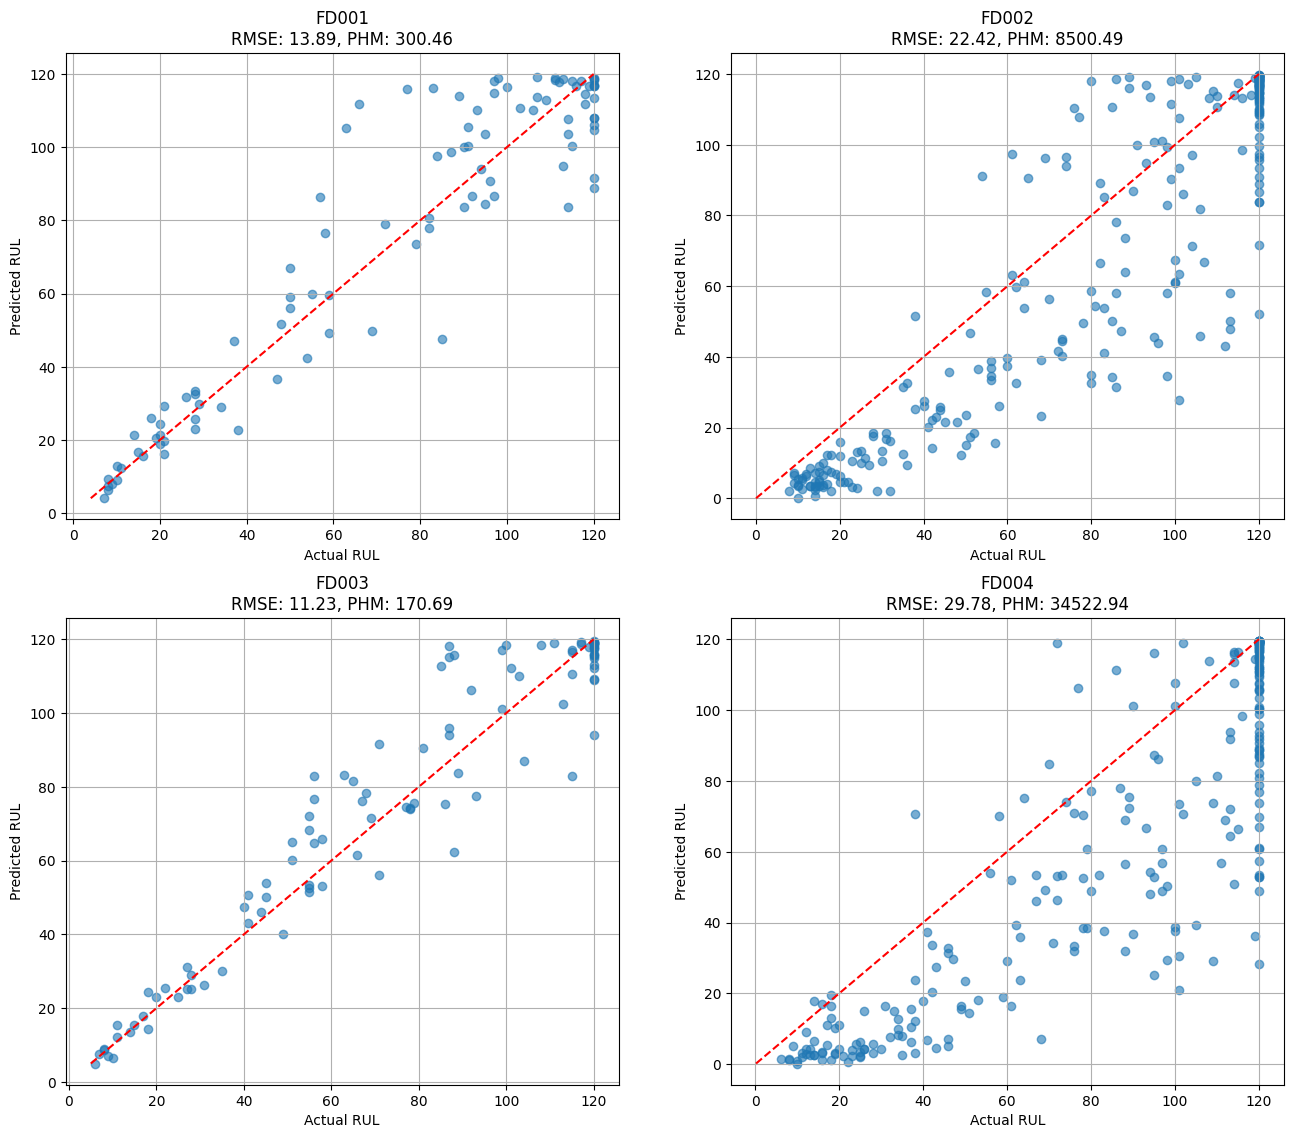

In [ ]:
from sklearn.model_selection import KFold
# Run pipeline with normal MSE as training metric
results_pipeline = pipeline(dataset_names, base_path)